<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/02_MLflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 機械学習の基本的な手順

* 注1: Wekaの操作説明は省略し，すべてscikit-learnを用いた説明に置き換えます．
* 注2: 「2.1.5節 ROC曲線を用いた結果の調整」は5章に移動します．

機械学習全体の手順は以下の図のようになります．

<img src="images/02/2-1.png" width="70%"/>

ここでは，Pythonを使って機械学習の基本的な手順を説明します．機械学習にPythonを使うメリットには以下のようなものがあります．
* データ処理や機械学習のパッケージが充実
* グラフ表示などの可視化が容易
* Jupyter Notebookで、実行手順を記録しながらコーディングが可能

機械学習パッケージscikit-learnを用いた機械学習の手順は以下のようになります．

<img src="images/02/2-2.png" width="70%"/>

### パッケージの読み込み

scikit-learn では，全体のパッケージである sklearn のサブパッケージとして，データの読み込みから，学習を行った結果表示までを行うための機能が提供されています．これらのサブパッケージから必要なメソッドやクラスをコードの冒頭で import して使用します．また，scikit-learn では処理の高速化のために数値計算パッケージ numpy を使用しているので，ほとんどすべてのコードで numpy の import が必要になります．これ以外に，グラフの表示のためのライブラリ matplotlib や，データ読み込みのためのパッケージ pandas も必要に応じて読み込んでおきます．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

## データ収集・整理

機械学習の第一段階はデータ収集です．購買記録からのパターンマイニングなどのように，使用するデータがあらかじめ存在する場合と，自分でタスクと問題を設定して，そのために必要なデータを集める場合とがあります．教師あり学習を行う場合には，さらに正解の付与作業が必要になります．

機械学習に用いる学習データは，概念的には多次元ベクトルの集合です．多次元ベクトルの集合を機械可読な形式で表現する場合，ベクトルの各要素をカンマで区切り，1行に1事例ずつデータを並べてゆくのが，もっとも単純な形式になります．この形式は CSV (Comma Separated Values) 形式とよばれ，表計算ソフトやテキストエディタで表示・編集・保存ができます．

また，scikit-learnには勉強のための7種類のtoyデータセットや，有名なデータセットを読み込むためのメソッドも用意されています．

http://scikit-learn.org/stable/datasets/index.html  

## 学習データの読み込み

ここでは，toyデータセット iris を用いて，基本的な学習手順を説明します．

irisはアヤメ (iris) の種類を，その萼（がく）の長さ (sepal length) ・幅 (sepal width) ，花びらの長さ (petal length) ・幅 (petal width) の，計四つの特徴を用いて識別するための学習データです．各事例には，Iris-setosa, Iris-versicolor, Iris-virginicaのいずれかが正解情報として付いています． 

変数 iris は，特徴ベクトル，正解データ，特徴名，データの説明などのさまざまな情報が詰まったBunchオブジェクトになります．

サンプルデータのいくつかには，DESCR 属性の値としてデータの概要・特徴の説明・統計情報などが記述されているので，表示して内容を確認しています．特徴ベクトルは data 属性の値として，また正解データは target 属性の値として格納されているので，ここでは，以降の章での数式を用いた説明に合わせて，特徴ベクトルの集合を X，正解データを y という変数に入れ直しておきます．

ここで，X は numpy の$n$次元アレイ (ndarray) で，データ数 $\times$ 特徴の次元数からなる150行4列の行列です．このように特徴ベクトルを行ベクトルに転置して，列方向に並べたものを**パターン行列**とよびます．また，y も numpy の$n$次元アレイで，150個の要素からなる列ベクトル（すなわち150行1列の行列）です．値はクラス名を表す文字列ではなく，それをクラス番号に置き換えた数値（iris データは3クラスなので 0, 1, 2）が入っています

In [2]:
iris = load_iris()
print(iris.DESCR)
X = iris.data
y = iris.target

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## 前処理

ここでは，前処理の方法として，次元削減と標準化を紹介します．

### 次元削減

**次元削減**とは，特徴ベクトルの次元数を減らすことです．せっかく用意した特徴を減らすと聞くと，不思議な感じがするかもしれません．しかし一般的には，高次元の特徴には冗長性が多く含まれます．また，次元数が増えれば増えるほど，学習データが高次元空間上に疎（まば）らに存在することになり，そのような疎らなデータから得られたモデルは，一般的に汎化能力が低いことがわかっています．これを「**次元の呪い**」とよびます．したがって，特徴ベクトルの次元削減は，より汎化能力の高いモデルを学習するという観点から，重要な前処理ということになります．ここでは，特徴数削減の手法として，**主成分分析**(Principal Component Analysis: PCA) を紹介します．以下の図に，2次元から1次元への削減を例として，主成分分析の手順を示します．

<img src="images/02/2-3.png" width="80%"/>

主成分分析とは，相関が高い特徴を複数含むような冗長な高次元空間を，冗長性の少ない低次元空間に写像する行列を求める操作です．次元削減の対象である高次元特徴空間上にデータがどのように散らばっているかという情報は，もとのデータの統計的性質を表す共分散行列によって表現することができます．この共分散行列の情報を基にして，低次元空間への写像をおこなう行列を作ってゆきます．

ここでは，主成分分析によって4次元データを2次元にする次元削減を行い，散布図を出力して，この識別問題がどのくらい難しいのかの見当をつけてみます．

まず，decomposition パッケージにある PCA クラスのインスタンスを作成します．削減後の次元数は，インスタンス作成時に n_components 引数の値として与えます．そして，主成分分析をおこなう fit_transform メソッドを，変換したいデータを引数に与えて呼び出します．結果はメソッドの戻り値として得られるので，それを変数 X2 に格納しておきます．X2 は 150行2列の行列となります．

In [3]:
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

この結果を，matplotlib パッケージを用いてグラフで出力します．グラフの種類は，2次元平面上にデータを点でプロットする散布図を使います．matplotlib.pyplot パッケージの plot メソッドを，第1引数として横軸の値の並び，第2引数として縦軸の値の並び，第3引数として点の種類を表す記号を与えて呼び出すと，以下のようなグラフが表示されます．

plotメソッドの第1, 第2引数にある X2\[y==0, 0\] のような記述は，行列 X2 の中から，ベクトル y の値が0にあたる行だけ取り出し，その0列目を抜き出すということを示しています．また，第3引数の1文字目は色，2文字目は点の形を示しています．たとえば，"ro" は赤 (red) の丸を表します．

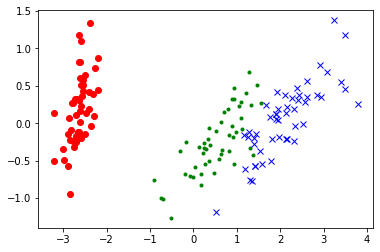

In [4]:
plt.plot(X2[y==0,0], X2[y==0,1],"ro")
plt.plot(X2[y==1,0], X2[y==1,1],"g.")
plt.plot(X2[y==2,0], X2[y==2,1],"bx")

### 標準化

特徴の値の範囲を揃えておく**標準化** (standardization)も，前処理としては重要な処理です．一般に，特徴は各次元それぞれ独立の基準で計測・算出するので，その絶対値や分散が大きく異なることがあります．これをベクトルとして組み合わせて，そのまま学習を行うと，絶対値の大きい特徴量の寄与が大きくなりすぎるという問題があるので，値のスケールを合わせる必要があります．また，入力の平均値を特定の値に合わせておくと，学習対象であるモデルのパラメータの初期値を，個別のデータセットに合わせて調整する必要がなくなります．このようなことを目的として，一般的には以下の式に従ってそれぞれの次元の平均値を0に，標準偏差を1に揃えます．ただし$mean_x$はその次元の平均値，$std_x$はその次元の標準偏差とします．この処理を標準化とよびます．
$$
x_{scaled} = \frac{x - mean_x}{std_x}
$$

ここでは，主成分分析の結果は，データのクラスごとのまとまり具合を見る程度にしておいて，識別には，もとの4次元データ X を使います．パターン行列 X に対しては，各特徴の平均と分散を揃える標準化処理を行います．scikit-learn では，さまざまな前処理が preprocessing サブパッケージに用意されています．標準化を行うメソッドは scale です．

この処理で平均0，標準偏差1になっていることは，X_scaled.mean(axis=0)，X_scaled.std(axis=0)の結果を表示させて確認することができます．なお，それぞれのメソッドの引数 axis=0 は，列単位でそれぞれの処理を行うことを指示しています．

In [5]:
X_scaled = preprocessing.scale(X)

## 評価基準の設定

学習に先立って，評価基準を設定しておきます．ここでは，教師あり・識別の場合の評価基準を考えます．この場合，学習データに対して正解率100%でも意味がありません．未知データに対してどれだけの正解率が期待できるかが評価のポイントですが，どうやって未知データで評価すればよいのでしょうか．

### 分割学習法

学習データが大量にある場合は，半分を学習用，残り半分を評価用として分ける方法が考えられます．この方法を**分割学習法**とよびます．評価用に半分というのは，多すぎるように見えるかもしれませんが，評価用データがあまりに少ないと，未知データの分布とまったく異なる可能性が高くなり，評価そのものが信頼できなくなります．また，モデルのパラメータの調整を行うような場合では，データを学習用・調整用・評価用と分けるケースもあります．

### 交差確認法

しかし，iris データは150事例しかないので，分割学習法で評価するのは難しそうです．このような場合，一般的には**交差確認法**(Cross Validation method: CV法)とよばれる方法を用いて評価します．この方法では，学習データを$m$個の集合に分割し，そのうちの$m-1$個で学習を行い，除外した残りの一つで評価を行い，その結果の平均を求めます．そして，その除外するデータを順に交換することで，合計$m$回の学習と評価を行います．これで，全データがひととおり評価に使われ，かつその評価時に用いられる識別器は評価用データを除いて構築されたものとなっています．$m$を交差数とよび，技術論文では交差数$m$を10とするケース (10-fold CV) や，データの個数とするケースがよく見られます．$m$がデータの個数の場合を**一つ抜き法**(leave-one-out method)とよびます．

<img src="images/02/2-4.png" width="70%"/>



### 学習

さて，いよいよ学習です．ここでは学習アルゴリズムとして，入力されたデータに近い学習データを近い順に$k$個選び，多数決などで所属するクラスを決定する**k-NN法** (k-Nearest Neighbor method)を使います．

<img src="images/02/2-5.png" width="50%"/>

k-NN法は，いわば学習データを集めるだけの学習法です．$k=1$の場合，識別したいデータともっとも近い学習データを探して，その学習データが属するクラスを答えとします．$k>1$の場合は，多数決をとるか，距離の重み付き投票で識別結果を決めます．このk-NN法で調整するべきパラメータは，以下のものがあります．

* 近傍として探索するデータ数 $k$  
　$k$が1の場合にもっとも複雑な境界となります．$k$が増えるに従って境界は滑らかになりますが，あまり大きいと識別性能が低下します．
* 距離尺度  
　通常は$\mbox{Dist}(\boldsymbol{x}, \boldsymbol{x}') = \sqrt{\sum_{i=1}^d (x_i - x'_i)^2}$で計算されるユークリッド距離を用います．値を持つ次元が少ない疎なデータの場合は，$\mbox{Dist}(\boldsymbol{x}, \boldsymbol{x}') = \sum_{i=1}^d (\vert x_i - x'_i \vert)$で計算されるマンハッタン距離が有効な場合もあります．
* 探索方法  
　通常は，入力と全データとの距離を計算してソートを行います．データが多い場合は，事前にデータを木構造化し，探索を効率よく行う場合もあります．

In [6]:
clf = KNeighborsClassifier(n_neighbors=1)
print(clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


交差確認法による性能評価はcross_val_scoreメソッドで行います．交差回数分の正解率のリストが戻り値として得られるので、それを利用して正解率の平均と95%信頼区間を表示します．

In [7]:
scores = cross_val_score(clf, X_scaled, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.95 (+/- 0.13)


### 混同行列からの評価指標の計算

まず，説明を単純にするために2クラス識別問題の評価法を考えます．2クラス問題では，入力がある概念に当てはまるか否かを判定します．たとえば，ある病気か否か，迷惑メールか否か，というような問題です．設定した概念に当てはまる学習データを正例 (positve) ，当てはまらないデータを負例 (negative) といいます．迷惑メールの識別問題では，迷惑メールが正例なので，これをpositiveと見なすのは少し変な気がしますが，惑わされないでください．あくまでも設定した概念に当てはまるか否かで，正例・負例が決まります．

さて，識別器を作成し，テストデータでその評価を行うと，その結果は以下の表のように表すことができます．正例を正解＋，負例を正解ー，識別器が正と判定したものを予測＋，負と判定したものを予測ーとします．この表のことを**混同行列**(confusion matrix)あるいは**分割表**(contingency table)とよびます．

||予測＋|予測－|
|:-----|:--:|:--:|
|正解＋ | 30 | 20 |
|正解－ | 10 | 40 |

対角成分が正解数，非対角成分が間違いの数を示します．たとえば，正解＋の行の数値は，正例50個のうち，識別器が正と判定したものが30個，負と判定したものが20個であったことを示します．この表から得られるもっとも単純な評価指標は，識別器が正しい答えを出した割合で，正解数を全データ数$(30+20+10+40=100)$で割ることで求めます．表の場合は$(30+40)/100=0.7$となり，この値を**正解率**(accuracy)とよびます．

実は，機械学習の評価は，正解率を算出して終わり，というほど単純なものではありません．たとえば，正例に比べて負例が大量にあるデータを考えてみましょう．もし，正例のデータがでたらめに判定されていても，負例のデータがほとんど正確に判定されていたとしたら，正解率は相当高いものになります．そのような状況を見極めるために，機械学習の結果はさまざまな指標で評価する必要があります．有効な指標を紹介する前に，まず，混同行列の各要素に，以下の表に示す名前をつけておきます．

||予測＋|予測－|
|:-----|:--:|:--:|
|正解＋ | true positive (TP) | false negative (FN) |
|正解－ | false positive (FP) | true negative (TN) |

たとえば，左上の要素は，正例に対して識別器が正 (positive) であると正しく (true) 判定したので，true positive といいます．一方，右上の要素は，正例に対して識別器が負 (negative) であると間違って (false) 判定したので，false negativeとよびます．前の語が判定の成否 (true or false) を，後の語が判定結果 (positive or negative) を表します．以後の式中で true positive の事例数を表すのに TP という略称を用います．ほかも同様です．

これらの定義を用いると，**正解率** (accuracy) は以下のように定義できます．
$$
Accuracy = \frac{TP+TN}{TP+FN+FP+TN}
$$

また，識別器が正と判断したときに，それがどれだけ信頼できるかという指標を表すために，**精度**(precision)が以下のように定義されます．
$$
Precision = \frac{TP}{TP+FP}
$$

さらに，正例がどれだけ正しく判定されているかという指標を表すために，**再現率**(recall)が以下のように定義されます．
$$
Recall = \frac{TP}{TP+FN}
$$

精度と再現率は一般にトレードオフの関係にあり，識別器によっては，パラメータ設定でその値を調整することができます．精度と再現率を総合的に判断するために，その調和平均をとったものを**F値**(F-measure)とよび，以下のように定義されます．

$$
F-measure = 2\times\frac{Precision \times Recall}{Precision + Recall}
$$

多クラス識別の評価法としては，クラスごとの精度や再現率を求め，その平均を計算するマクロ平均と，各クラスでの混同行列を作成し，それらを集計するマイクロ平均とがあります。各クラスの事例数に違いが大きいときは，マイクロ平均または事例数で重みをつけたマクロ平均を用います．

<img src="images/02/2-7.png" width="70%"/>

### 分割学習法での評価

train_test_splitメソッドでデータを分割します．評価用データの割合は引数test_sizeで指定します．

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

学習用データで識別器の学習を行います．

In [9]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

評価用データに対する混同行列と各種の評価指標を出力します．

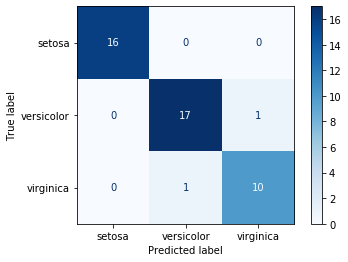

In [10]:
plot_confusion_matrix(clf, X_test, y_test,
                      display_labels=iris.target_names,
                      cmap=plt.cm.Blues,
                      normalize=None)

In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.94      0.94      0.94        18
   virginica       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



## 参考

* PCA https://scikit-learn.org/stable/modules/decomposition.html#pca
* Cross validation https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
* kNN https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
* Metrics https://scikit-learn.org/stable/modules/model_evaluation.html